RMSE: 0.401528


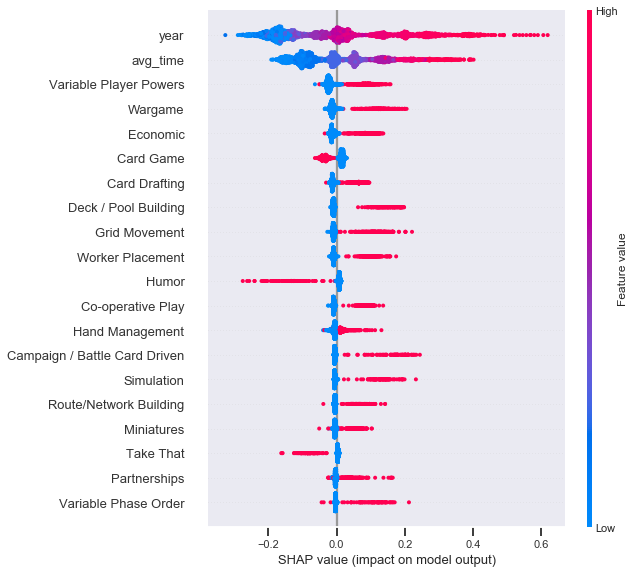

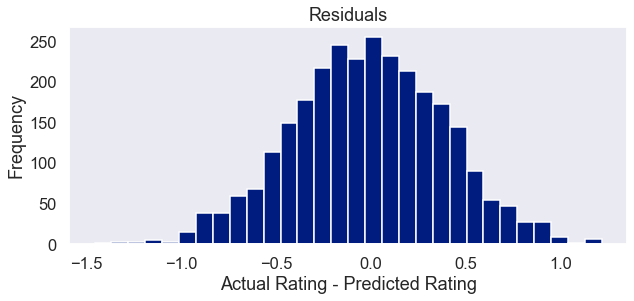

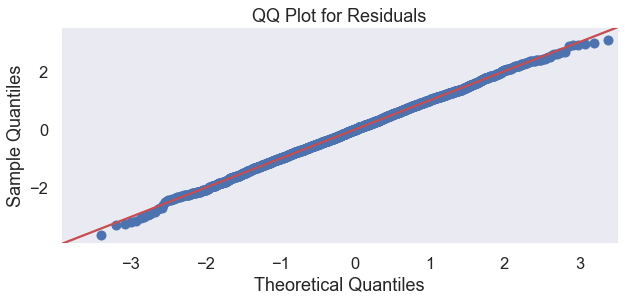

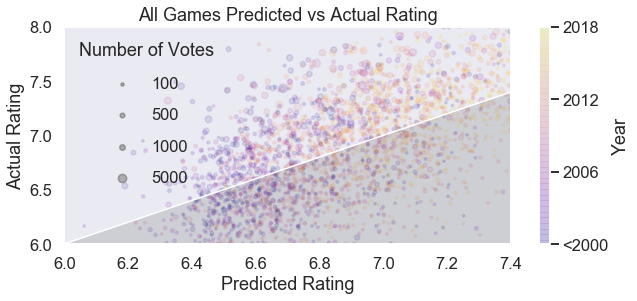

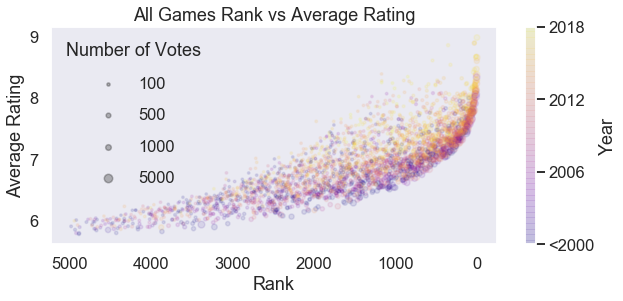

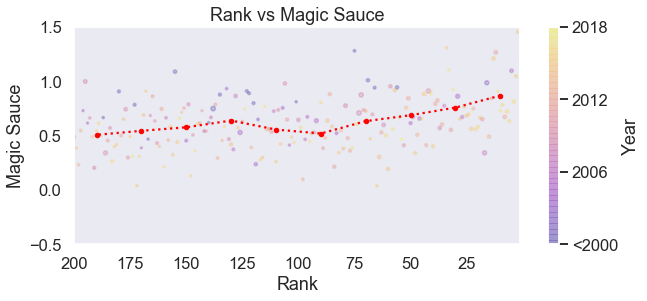

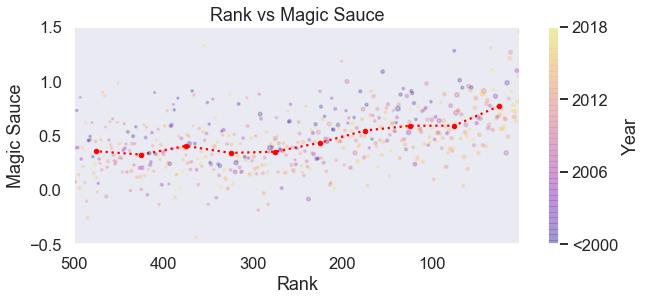

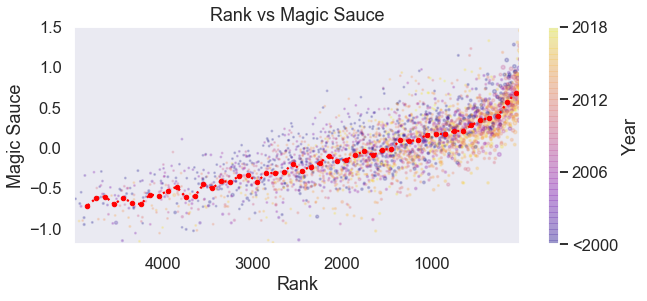

In [479]:
import math
import graphviz
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import operator
import matplotlib
import matplotlib.pyplot as plt
import statistics

from pylab import rcParams

def process_data(file_name):
    #filter by rank
    min_rank = 5000
    max_rank = 1
    data_original = pd.read_csv(file_name )
    data_original=data_original.set_index('game_id')
    data=data_original.loc[data_original['rank'] >= max_rank]
    data=data.loc[data_original['rank'] <= min_rank]
    
    #normalize year to years past 2000, older games are 0
    data['year']=(data['year']-2000);
    data['year']=data['year'].clip(lower=0)
    
    #log number of votes
    data['log_num_votes']=np.log10(data['num_votes'])
    data['log_owned']=np.log10(data['owned'])
    
    data=data[data['num_votes'] > 500]
    
    #clamp other variables to avoid weirdness
    data['avg_time']=data['avg_time'].clip(upper=300)
    data['max_players']=data['max_players'].clip(upper=8)
    #y_box, lmb = boxcox(data['avg_rating'])
    #data['avg_rating_bc']= y_box
    
    #change spaces to underscores and cleanup
    data.columns = (data.columns.str.strip().str.replace(' ', '_')
                    .str.replace('_/_','/').str.replace('(', '').str.replace(')', ''))
    
    
    #create binary variables for categories with at least 200 games
    x = (data
    .category
    .str.split(r', ',expand=True)
    .stack().reset_index(level=1, drop=True)
    .to_frame('category'));
    cat = pd.get_dummies(x,prefix='', prefix_sep='', columns=['category']).groupby(level=0).sum()
    cat.drop([col for col, val in cat.sum().iteritems() if val < 20], axis=1, inplace=True)
    
    #create binary variables for mechanics with at least 200 games
    x = (data
    .mechanic
    .str.split(r', ',expand=True)
    .stack().reset_index(level=1, drop=True)
    .to_frame('mechanic'))
    mech=pd.get_dummies(x,prefix='', prefix_sep='', columns=['mechanic']).groupby(level=0).sum()
    mech.drop([col for col, val in mech.sum().iteritems() if val < 20], axis=1, inplace=True)
    
    if 'none' in mech.columns:
        mech.drop('none', axis=1, inplace=True)
    
    #combine frames
    data=data.merge(cat, on='game_id')
    data=data.merge(mech, on='game_id')
    
    #merge memory columns
    if 'Memory_x' in data:
        data=data.assign(Memory=data.Memory_x|data.Memory_y)
        data.drop('Memory_x', axis=1, inplace=True)
        data.drop('Memory_y', axis=1, inplace=True)
    return data, mech, cat
def run_xgb(Xtest,Xtrain, ytest, ytrain):
    from sklearn.metrics import mean_squared_error
    dtrain = xgb.DMatrix(Xtrain, label=ytrain)
    dtest = xgb.DMatrix(Xtest, label=ytest)
    
    # set xgboost params
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 6, reg_lambda = 1, alpha = 10, n_estimators = 60)
    xg_reg.fit(Xtrain,ytrain)

    #make predictions and compute rmse
    preds = xg_reg.predict(Xtest)
    rmse = np.sqrt(mean_squared_error(ytest, preds))
    explainer = shap.TreeExplainer(xg_reg)
    return preds, rmse, explainer
def games_qqresid(data,preds,Xtest,res):
    #scatter(preds,data.loc[foo.tolist()]['rank'].tolist())
    #adjpreds = inv_boxcox(preds.tolist(),lmb)
    adjpreds = preds
    plt.hist(res,bins=30)
    plt.title('Residuals')
    plt.xlabel('Actual Rating - Predicted Rating')
    plt.ylabel('Frequency')
    plt.show()
def games_scatter(data):
    fig, ax=plt.subplots()
    scatter=plt.scatter(data['predicted_rating'],
                        data['avg_rating'],
                        s=list(map(lambda x: x**0.5,data['num_votes'])),
                        c= list(map(lambda x: x+2000,data['year'])), 
                        alpha=0.1, 
                        marker=".", 
                        cmap='plasma')
    plt.axis(aspect='equal')
    cbar=plt.colorbar(label='Year',ticks=[2000,2006, 2012, 2018])
    cbar.ax.set_yticklabels(['<2000', '2006', '2012', '2018'])
    plt.title('All Games Predicted vs Actual Rating')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Actual Rating')
    #plt.clim(3, 7)
    for v in [100, 500, 1000,5000]:
         plt.scatter([],[],c='k', alpha=0.3, s=v**0.5, label=str(v))
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Number of Votes')
    plt.xlim(6,7.4)
    plt.ylim(6,8)
    plt.fill([6,7.4,7.4,6],[6,6,7.4,6], '#0f0f0f20')
    plt.show()
    fig, ax=plt.subplots()
    scatter=plt.scatter(data['rank'],
                        data['avg_rating'],
                        s=list(map(lambda x: x**0.5,data['num_votes'])),
                        c= list(map(lambda x: x+2000,data['year'])), 
                        alpha=0.1, 
                        marker=".", 
                        cmap='plasma')
    plt.axis(aspect='equal')
    cbar=plt.colorbar(label='Year',ticks=[2000,2006, 2012, 2018])
    cbar.ax.set_yticklabels(['<2000', '2006', '2012', '2018'])
    plt.title('All Games Rank vs Average Rating')
    plt.xlabel('Rank')
    plt.ylabel('Average Rating')
    #plt.clim(3, 7)
    for v in [100, 500, 1000,5000]:
         plt.scatter([],[],c='k', alpha=0.3, s=v**0.5, label=str(v))
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Number of Votes')
    plt.gca().invert_xaxis()
    plt.show()
def magic_scatter(data,bin_size,xmin,xmax,ymin,ymax):
    fig, ax=plt.subplots()
    averages_x=[]
    averages_y=[]
    for i in range(xmin//bin_size,xmax//bin_size):
        averages_x.append(bin_size/2+bin_size*i)
        averages_y.append(statistics.mean(data[(data['rank'] < bin_size*(i+1)) & (data['rank']> bin_size*i)]['magic_sauce']))
    scatter=plt.scatter(data['rank'].tolist(),
                   data['magic_sauce'].tolist(),
                   alpha=0.2,
                   c = list(map(lambda x: x+2000,data['year'].tolist())),
                   cmap = 'plasma',
                   s = list(map(lambda x: 0.3*x**0.5,data['num_votes'].tolist())),
                   marker = '.')
    cbar=plt.colorbar(label='Year',ticks=[2000,2006, 2012, 2018])
    cbar.ax.set_yticklabels(['<2000', '2006', '2012', '2018'])
    plt.title('Rank vs Magic Sauce')
    plt.xlabel('Rank')
    plt.ylabel('Magic Sauce')
    #ax.set_xscale('log')
    #plt.clim(3, 7)
    for v in [500, 1000,5000]:
        plt.scatter([],[],c='k', alpha=0.3, s=0.3*v**0.5, label=str(v))
    #plt.legend(scatterpoints=1, frameon=False, ncol=3,labelspacing=1, title='Number of Votes')
    plt.xlim(xmax,xmin)
    plt.ylim(ymin,ymax)
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    plt.plot(averages_x, averages_y, c= "red", marker='.', linestyle=':')
    plt.show()
def print_clusters(data,num_games):
    for i in range(0,max(data['cluster'].tolist())+1):
        C1 = data
        C1 = C1[C1['cluster'] == i]
        C2 = C1#[C1['rank'] < 200]
        print("\nCluster " + str(i+1))
        print(C2[['names','rank']].sort_values(by = ['rank']).head(num_games))
        sums=C1.drop(['names','rank','cluster','tsne_x','tsne_y'], axis=1).sum().to_frame()
        sums.columns=['Number']
        C3=(sums.sort_values(by=['Number'], ascending = False).head(5))
        C3.columns=['Percentage']
        print(C3.mul(100/len(C1.index)).round(2))
def do_analysis(data,mech,cat):
    from sklearn.preprocessing import LabelEncoder
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    from sklearn.datasets import dump_svmlight_file
    from sklearn.externals import joblib
    from sklearn.metrics import precision_score
    from sklearn.metrics import mean_squared_error
    import scipy.stats as stats
    
    import statsmodels.api as sm
    
    
    feature_columns_to_use = ( ['year','avg_time']+mech.columns.values.tolist()+cat.columns.values.tolist())
    
    #split into fifths
    r_state=523
    data1=data.sample(frac=0.2, random_state = r_state)
    data_temp = data.drop(data1.index)
    data2=data_temp.sample(frac=0.25, random_state = r_state)
    data_temp = data_temp.drop(data2.index)
    data3=data_temp.sample(frac=1/3, random_state = r_state)
    data_temp = data_temp.drop(data3.index)
    data4=data_temp.sample(frac=0.5, random_state = r_state)
    data5=data_temp.drop(data4.index)
    
    X1, Xtemp, y1, ytemp = train_test_split(data1[list(dict.fromkeys(feature_columns_to_use))], data1['avg_rating'], test_size=0, random_state=11)
    X2, Xtemp, y2, ytemp = train_test_split(data2[list(dict.fromkeys(feature_columns_to_use))], data2['avg_rating'], test_size=0, random_state=11)
    X3, Xtemp, y3, ytemp = train_test_split(data3[list(dict.fromkeys(feature_columns_to_use))], data3['avg_rating'], test_size=0, random_state=11)
    X4, Xtemp, y4, ytemp = train_test_split(data4[list(dict.fromkeys(feature_columns_to_use))], data4['avg_rating'], test_size=0, random_state=11)
    X5, Xtemp, y5, ytemp = train_test_split(data5[list(dict.fromkeys(feature_columns_to_use))], data5['avg_rating'], test_size=0, random_state=11)
    
    
    preds1, rmse1, explainer1 = run_xgb(X1,pd.concat([X2,X3,X4,X5]), y1, pd.concat([y2,y3,y4,y5]))
    preds2, rmse2, explainer2 = run_xgb(X2,pd.concat([X1,X3,X4,X5]), y2, pd.concat([y1,y3,y4,y5]))
    preds3, rmse3, explainer3 = run_xgb(X3,pd.concat([X2,X1,X4,X5]), y3, pd.concat([y2,y1,y4,y5]))
    preds4, rmse4, explainer4 = run_xgb(X4,pd.concat([X2,X3,X1,X5]), y4, pd.concat([y2,y3,y1,y5]))
    preds5, rmse5, explainer5 = run_xgb(X5,pd.concat([X2,X3,X4,X1]), y5, pd.concat([y2,y3,y4,y1]))
    print("RMSE: %f" % (np.sqrt((rmse1**2+rmse2**2+rmse3**2+rmse4**2+rmse5**2)/5)))
    
    #xgb.plot_tree(xg_reg, num_trees=5)
    #plt.rcParams['figure.figsize'] = [200, 40]
    #plt.show()
    
    shap.initjs()
    shap_values=explainer1.shap_values(pd.concat([X2,X3,X4,X5]))
    
                                       
                                        
    #Xtrain2=Xtrain.reset_index()
    # for test_index, row in Xtrain2.iterrows():
    #     if data_original.loc[Xtrain2.iloc[test_index].game_id]['rank'] <5:
    #         print(data_original.loc[Xtrain2.iloc[test_index].game_id]['names'])
    #         print("Rank", data_original.loc[Xtrain2.iloc[test_index].game_id]['rank'], data_original.loc[Xtrain2.iloc[test_index].game_id]['avg_rating'])
    #         shap.force_plot(explainer.expected_value, shap_values[test_index,:],Xtrain.iloc[test_index,:], matplotlib=True)
    #         plt.show()
    
    shap.summary_plot(shap_values, pd.concat([X2,X3,X4,X5]), title='SHAP Values for Light Games')
    
    rcParams['figure.figsize'] = 10, 4
    
    X=pd.concat([X1, X2, X3, X4, X5])
    data_new = pd.concat([data1,data2,data3,data4,data5])
    preds = np.concatenate((preds1,preds2,preds3,preds4,preds5))
    data_new['predicted_rating']=preds
    foo=X.reset_index()['game_id']
    actualy = data_new.loc[foo.tolist()]['avg_rating'].tolist()
    res = list(map(operator.sub, preds, actualy))
        
    games_qqresid(data_new,preds,X,res)
        
    fig=sm.qqplot(np.asarray(res),stats.t,fit=True,line='45')
    plt.title('QQ Plot for Residuals')
    plt.show()
    
    
    X.insert(2,"predicted_rating",preds,True)
    Xtest2=X[['predicted_rating']].join(data)
    Xtest2 = Xtest2[Xtest2['num_votes'] > 500]
    Xtest2['magic_sauce']=Xtest2['avg_rating']-Xtest2['predicted_rating']
    Xtest2=Xtest2.sort_values(by=['magic_sauce'], ascending=False)
    #pd.set_option("display.max_rows", 20)
    
    games_scatter(Xtest2)
    
    #plt.ylim(6,8)
    magic_scatter(Xtest2,20, 1, 200,-.5,1.5)
    magic_scatter(Xtest2,50, 1, 500,-.5,1.5)
    magic_scatter(Xtest2,100, 1, 4999,-1.2,1.5)
    top_games = Xtest2[['names','num_votes','magic_sauce','avg_rating','rank']][Xtest2['num_votes'] > 500].head(20)
    return Xtest2, data_new, cat, mech, top_games
def do_clustering(data_with_ratings, cat, mech, data, algorithm, args, kwds):
    #from sklearn.manifold import TSNE
    #import umap
    X=(cat.join(mech, rsuffix="_m")
       .join(data['rank'])
       #.join(data['avg_time'].div(240)))
      )
    X = X[X['rank'] <= 500]
    X = X.drop(['rank'], axis=1)
    #clusters = (KPrototypes(n_clusters = 8, init='Huang', n_init = 1)
    #            .fit_predict(X, categorical =list(range(0,len(X.columns)-3))))
    clusters = algorithm(*args, **kwds).fit_predict(X)#, categorical = list(range(0,len(X.columns)-2)))
    
    #X_tsne = umap.UMAP(n_neighbors = 5, min_dist = 0.3,
    #                   metric = 'cosine' ).fit_transform(X)
    #plt.show()
    X['cluster']=clusters;
    return clusters, X.join(data[['names','rank']])
def do_tsne(data_with_ratings, cat, mech, data, args, kwds):
    from sklearn.manifold import TSNE
    X=(cat.join(mech, rsuffix="_m")
       .join(data['rank'])
       #.join(data['avg_time'].div(240)))
      )
    X = X[X['rank'] <= 500]
    X = X.drop(['rank'], axis=1)
    X_tsne = TSNE(*args,**kwds).fit_transform(X)
    return X_tsne
def scatter_clusters(X_tsne, X, clusters, names):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(32,32))
    cluster_names = []
    for i in range(0,len(clusters)):
        cluster_names.append(names[clusters[i]])

    pal = sns.color_palette('husl',len(names))

    
    ax = sns.scatterplot(X_tsne[:,0],
                    X_tsne[:,1], 
                    hue = cluster_names, #list(map(lambda x: x+1,clusters.tolist())),
                    hue_order = names,
                    palette = pal,
                    legend = 'full'
                    )
    sns.set_style('dark', {'legend.frameon':True})
    leg = plt.legend(fancybox=True, framealpha = 0)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')
    
    X['tsne_x']=X_tsne[:,0]
    X['tsne_y']=X_tsne[:,1]
    X['cluster']=clusters
    data = X[X['rank'] <= 200]
    for label, x, y, cl in zip(data['names'], data['tsne_x'], data['tsne_y'], data['cluster']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',color = pal[cl],
            arrowprops=dict(arrowstyle = '->',color=pal[cl], connectionstyle='arc3,rad=0'))
    return


data, mech, cat = process_data("bgg_db_1806.csv")
data_with_ratings,data,mech,cat, top_games = do_analysis(data,mech,cat)



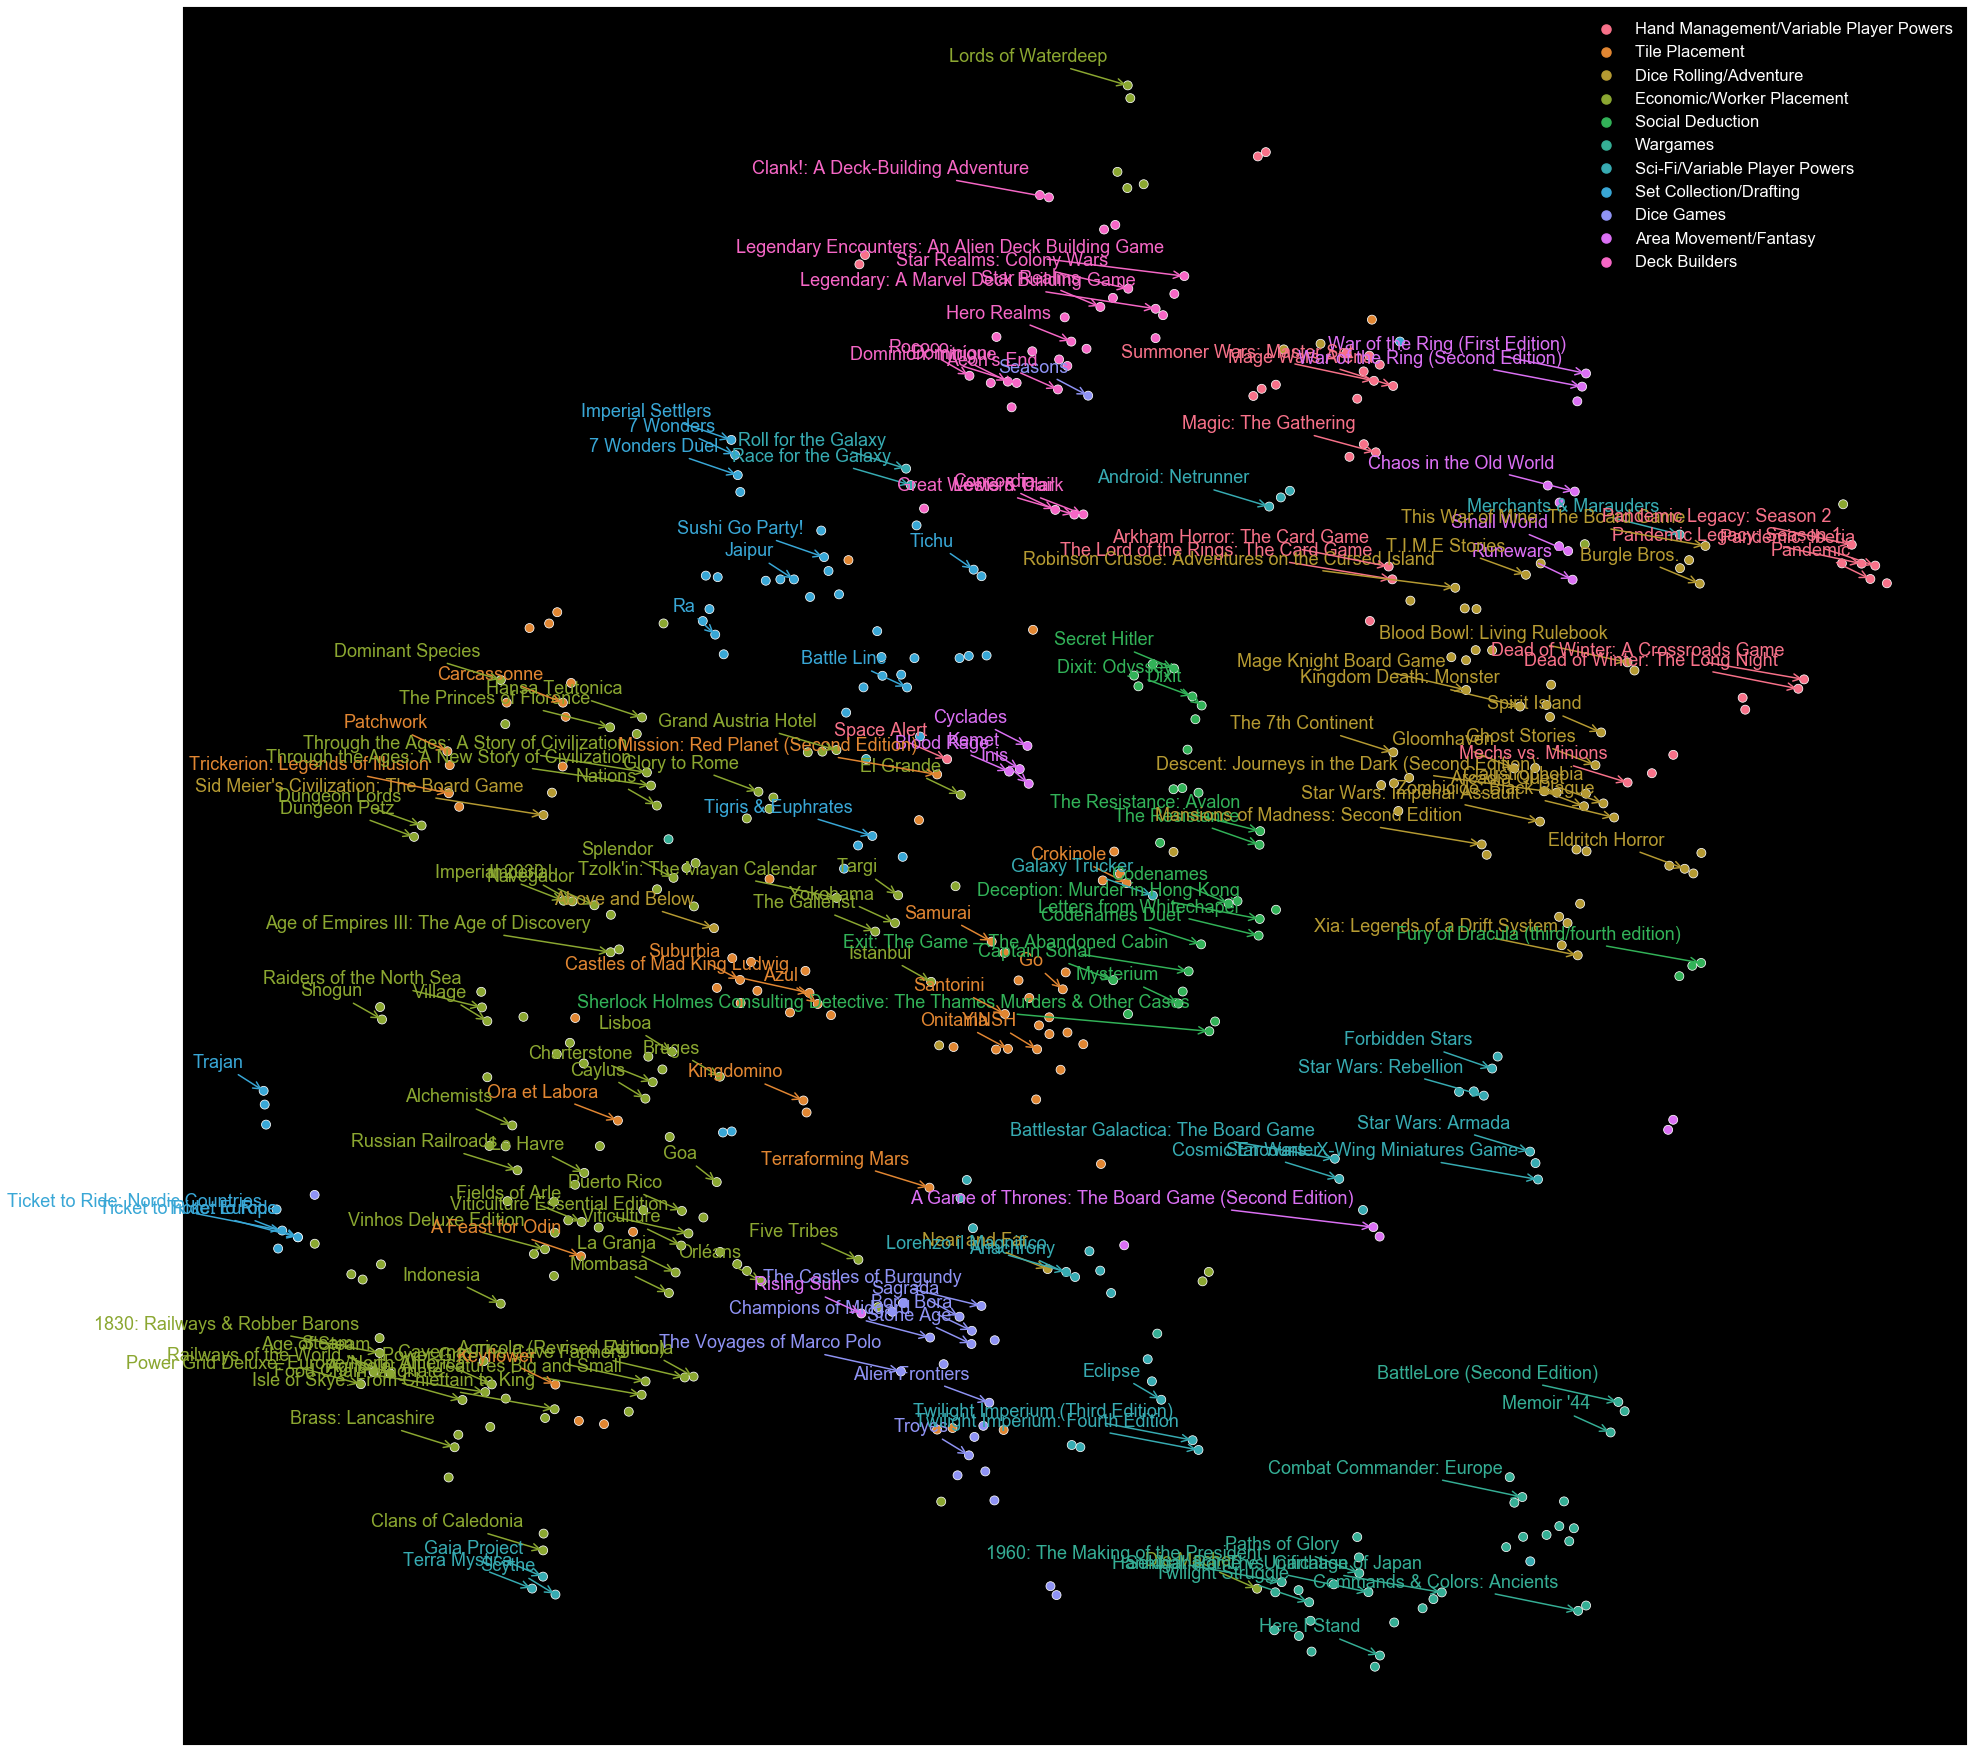

In [469]:
import sklearn.cluster as cluster
saved_clustering = True
saved_tsne = True
if not saved_data:
    clusters, cluster_data = do_clustering(data_with_ratings, cat, mech,
                                        data,
                                        cluster.AgglomerativeClustering,(),
                                        {'n_clusters':11,
                                        'affinity':'euclidean',
                                        'linkage':'ward'})
if not saved_tsne:
    X_tsne = do_tsne(data_with_ratings, cat, mech, data,(),
                     {'init':'pca',
                     'n_iter':5000,
                     'perplexity':5, 
                     'angle':0,
                     'learning_rate':200,
                     'random_state':5
                     })     

names = ['Hand Management/Variable Player Powers',
        'Tile Placement',
        'Dice Rolling/Adventure',
        'Economic/Worker Placement',
        'Social Deduction',
        'Wargames',
        'Sci-Fi/Variable Player Powers',
        'Set Collection/Drafting',
        'Dice Games',
        'Area Movement/Fantasy',
        'Deck Builders']


scatter_clusters(X_tsne, cluster_data, clusters,names)


In [511]:
MS = data_with_ratings.sort_values('magic_sauce', ascending = False)
MS = MS.reset_index()
MS = MS.set_index(['names'])
MS = MS[['rank','magic_sauce','avg_rating']]
MS = MS[ MS['rank'] <= 500 ]
from IPython.core.display import HTML
MS.head(100).to_csv('magic.csv')


In [450]:
print_clusters(cluster_data,10); 


Cluster 1
                                        names  rank
game_id                                            
161936              Pandemic Legacy: Season 1     2
205637           Arkham Horror: The Card Game    20
209010                      Mechs vs. Minions    24
221107              Pandemic Legacy: Season 2    33
150376      Dead of Winter: A Crossroads Game    64
30549                                Pandemic    73
198928                       Pandemic: Iberia    90
77423    The Lord of the Rings: The Card Game   105
101721                        Mage Wars Arena   141
93260               Summoner Wars: Master Set   144
                        Percentage
Hand Management              94.12
Variable Player Powers       88.24
Co-operative Play            55.88
Card Game                    55.88
Fighting                     47.06

Cluster 2
                              names  rank
game_id                                  
167791            Terraforming Mars     4
177736            

59294                                             Runewars   147
                        Percentage
Area Movement               100.00
Fantasy                      78.95
Fighting                     63.16
Hand Management              63.16
Variable Player Powers       63.16

Cluster 11
                                                     names  rank
game_id                                                         
193738                                 Great Western Trail     9
124361                                           Concordia    22
40834                                   Dominion: Intrigue    59
201808                   Clank!: A Deck-Building Adventure    61
36218                                             Dominion    72
147020                                         Star Realms    87
146652   Legendary Encounters: An Alien Deck Building Game    88
129437              Legendary: A Marvel Deck Building Game   125
140620                                       Lewis & Clark   13

In [ ]:


* Distributions for major numerical variables
* Commonality of Traits
* t-SNE Traits
* Discuss regression model
* Prediction vs actual plot
* Residuals and QQ
* Tree examples
* SHAP for year
* SHAP for number of votes
* SHAP for average time
* SHAP for weight
* Ratings histograms for major features compared to baseline
* Regression with only characteristics

In [468]:
#Save Data
import pickle
#with open('objs.pkl','wb') as f:
#    pickle.dump([X_tsne, cluster_data, clusters,names],f)
  

#Load Data
#with open('objs.pkl','rb') as f:
#    X_tsne, cluster_data, clusters,names =pickle.load(f)

In [503]:
MS

[['rank', 'magic_sauce', 'avg_rating']]